In [1]:
import os
from PIL import Image
import cv2 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
#import matplotlib.image as mpimg
import networkx as nx
import torch
import torch.nn as nn
import dgl
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from dgl.nn import GraphConv, HeteroGraphConv
import dgl.function as fn
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import pickle
global_resize_image = (512,512)

C:\Users\EXTREME_RED\AppData\Local\Temp\ipykernel_2080\1425036893.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
with open('train_embedding_matrix.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)
print(embedding_matrix.shape) 
#print(embedding_matrix)
vocab_size = embedding_matrix.shape[0]   
print(vocab_size)

(4808, 200)
4808


In [305]:
'''class CustomModel(nn.Module):
    def __init__(self, input_dim, gcn_hidden_dim, lstm_hidden_dim, output_dim, num_layers):
        super(CustomModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.dropout = nn.Dropout(0.5)
        self.gcn1 = dgl.nn.GraphConv(input_dim, gcn_hidden_dim, weight=True, bias=False, allow_zero_in_degree=True)
        self.gcn2 = dgl.nn.GraphConv(gcn_hidden_dim, gcn_hidden_dim,weight=True,bias=False, allow_zero_in_degree=True)
        self.bilstm = nn.LSTM(lstm_hidden_dim * 2, lstm_hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(lstm_hidden_dim * 2, gcn_hidden_dim)
        self.linear2 = nn.Linear(gcn_hidden_dim, output_dim)

        # Call flatten_parameters() for the LSTM module
        self.bilstm.flatten_parameters()

    def forward(self, graph, features):
        h = self.gcn1(graph, graph.ndata['features'])
        h = F.relu(h)
        h = self.gcn2(graph, h)
        h = F.relu(h)
        lstm_input = h.view(h.size(0), -1)
        h, _ = self.bilstm(lstm_input.unsqueeze(1))
        h = self.linear1(h[-1, :, :])
        h = F.relu(h)
        h = self.linear2(h)
        output = F.softmax(h, dim=1)
        return output'''


In [ ]:
# Define your GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, edge_feats):
        super(GCN, self).__init__()
        self.edge_feats = edge_feats
        self.edge_linear = nn.Linear(edge_feats, hidden_feats)  # Linear layer for edge features
        self.conv1 = GraphConv(in_feats, hidden_feats)
        self.conv2 = GraphConv(hidden_feats, hidden_feats)

    def forward(self, g, features):
        src_emb = features[g.edges()[0]]
        dst_emb = features[g.edges()[1]]
        w = torch.sub(src_emb, dst_emb)
        w = self.edge_linear(w)
        g.edata['w'] = w

        # First graph convolution layer
        h = self.conv1(g, features)
        h = F.relu(h)

        # Update node features
        g.ndata['h'] = h
        g.update_all(fn.u_mul_e('h', 'w', 'm'), fn.sum('m', 'h'))
        h = g.ndata.pop('h')
        # Second graph convolution layer
        h = self.conv2(g, h)
        h = F.relu(h)

        g.ndata['h'] = h
        g.apply_edges(fn.u_mul_v('h', 'h', 'w'))

        return h
in_feats =  4096
hidden_feats = 256  # Number of hidden units
edge_feats = in_feats  # Number of edge features, same as input features for simplicity
GCN_model = GCN(in_feats, hidden_feats, edge_feats)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.W = nn.Linear(in_features, out_features, bias=bias)
        self.edge_weights = nn.ModuleDict()

    def forward(self, inputs, edges):
        outputs = []
        for edge_type in edges:
            neighbors = inputs[edges[edge_type]]
            neighbor_sum = neighbors.sum(dim=1)
            gated_neighbor_sum = self.edge_weights[edge_type](neighbor_sum)
            gated_neighbor_sum = F.sigmoid(gated_neighbor_sum) * neighbor_sum
            output = self.W(torch.cat([inputs, gated_neighbor_sum], dim=1))
            outputs.append(output)
        return torch.sum(torch.stack(outputs), dim=0)

class GCN_LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_edges):
        super(GCN_LSTM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.gcn = GCNLayer(embed_dim, hidden_dim)
        self.num_edges = num_edges
        self.init_edge_weights()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(2*hidden_dim, vocab_size)

    def init_edge_weights(self):
        for i in range(self.num_edges):
            self.gcn.edge_weights[str(i)] = nn.Linear(self.gcn.in_features, 1)

    def forward(self, captions, regions, edges):
        embeds = self.embed(captions)
        gcn_inputs = torch.cat([embeds, regions], dim=1)
        gcn_outputs = self.gcn(gcn_inputs, edges)
        lstm_outputs, _ = self.lstm(gcn_outputs)
        attention_weights = F.softmax(self.attention(lstm_outputs), dim=1)
        attended_features = (attention_weights * lstm_outputs).sum(dim=1)
        outputs = self.fc(torch.cat([attended_features, regions.mean(dim=1)], dim=1))
        return outputs

In [22]:
class CustomModel(nn.Module):
    def __init__(self, input_dim, gcn_hidden_dim, lstm_hidden_dim, output_dim, num_layers, dense_dim):
        super(CustomModel, self).__init__()

        self.conv1 = GraphConv(input_dim, gcn_hidden_dim, allow_zero_in_degree=True)
        self.conv2 = GraphConv(gcn_hidden_dim, gcn_hidden_dim, allow_zero_in_degree=True)
        
        self.encode = nn.Linear(input_dim, gcn_hidden_dim)
        # Linear layer for edge features
        self.edge_linear = nn.Linear(gcn_hidden_dim * 2, gcn_hidden_dim)

        self.text_encoder = nn.Sequential(
            nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True),
            nn.Dropout(0.5),
            nn.LSTM(200, 256, batch_first=True))
       
        self.decoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, vocab_size),
            nn.Softmax(dim=-1)
        )
    def forward(self, graph, description_X, Complete_Image):
        features = graph.ndata['features']
        image_feature = self.encode(Complete_Image)
        #print("image feature:", image_feature.shape)
        # First graph convolution layer
        '''h = self.conv1(graph, features)
        h = F.relu(h)
        # Second graph convolution layer
        h = self.conv2(graph, h)
        h = F.relu(h)
        #print(h.shape)
        # Edge features computation
        src_features = h[graph.edges()[0]]
        #print(src_features.shape)
        dst_features = h[graph.edges()[1]]
        #print(dst_features.shape)
        edge_features = torch.cat((src_features, dst_features), dim=2)
        #print(edge_features.shape)
        edge_features = self.edge_linear(edge_features)
        edge_features = F.relu(edge_features)
        print("edge_features:",edge_features.shape)
        # Assign computed edge features to the graph
        graph.edata['edge_features'] = edge_features
        edge_features = dgl.mean_edges(graph, 'edge_features')
        #print(edge_features)
        edge_features=edge_features[:,-1, :]
        print("edge_features:",edge_features.shape)'''

        image_feature=image_feature[:,-1, :]
        # Text Encoder
        text_features, _ = self.text_encoder(description_X)
        #print("text_features:",text_features.shape)
        text_features = text_features[:,-1, :]# Get the last output of LSTM
        #text_features = text_features.unsqueeze(0)
        #("text_features:",text_features.shape)
        # Combine image and text features
        combined_features = torch.cat((image_feature, text_features), dim=1)


        # Decoder
        output = self.decoder(combined_features)
        
        return output.squeeze(0)


In [23]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, file_path):
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        self.Image_names = data["image_names"]
        self.Graph_list = data["Graph_list"]
        self.Complete_Image_list = data["Complete_Image_list"]
        self.Descriptions_X = data["Descriptions_X"]
        self.Descriptions_y = data["Descriptions_y"]

    def __len__(self):
        return len(self.Image_names)

    def __getitem__(self, idx):
        return self.Image_names[idx], self.Graph_list[idx],self.Complete_Image_list[idx], self.Descriptions_X[idx], self.Descriptions_y[idx]

def collate_fn(batch):
    image_names, graphs, Complete_Image, descriptions_x, descriptions_y = zip(*batch)

    # Pad and batch descriptions
    #padded_descriptions_x, descriptions_x_lengths = pad_sequence(descriptions_x, batch_first=True)
    #padded_descriptions_y, descriptions_y_lengths = pad_sequence(descriptions_y, batch_first=True)

    # Batch graphs
    batched_graphs = dgl.batch(graphs)

    # Batch images (assuming they are already tensors)
    #batched_images = torch.stack(Complete_Image, dim=0)

    return image_names, batched_graphs, Complete_Image, descriptions_x, descriptions_y

file_path = "Encoded_Image_Graph_data.pkl"

# dataset instance
dataset = CustomDataset(file_path)

batch_size = 6
shuffle = True

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    collate_fn=collate_fn
)
'''for image_names, batched_graphs, Complete_Image, descriptions_X, descriptions_y,  in dataloader:
    print(batched_graphs.batch_size)
    print(batched_graphs)
    print(batched_graphs.batch_num_nodes())
    print(batched_graphs.batch_num_edges())
    feature = batched_graphs.ndata['features']
    print("feature shape:", feature.shape)
    Complete_Image = torch.tensor(Complete_Image, dtype=torch.float32)
    descriptions_X = torch.stack(descriptions_X, dim=0)
    descriptions_y = torch.stack(descriptions_y, dim=0)
    print(Complete_Image.shape)
    print(descriptions_X.shape)
    print(descriptions_y.shape)'''
# Accessing data using DataLoader
'''for image_names, graph, complete_image, description_X, descriptions_y in dataset:
    print(graph.batch_size)
    print(graph.batch_num_nodes())
    print(graph.batch_num_edges())
    feature = graph.ndata['features']
    print("feature shape:", feature.shape)
    print("Graphs:", graph)
    #print("Features:", graph.ndata)
    #print("description_X:", description_X)
    #print(type(description_X))
    print(description_X.shape)
    #print("descriptions_y:", descriptions_y)
    #print(type(descriptions_y))
    print(descriptions_y.shape)'''


'for image_names, graph, complete_image, description_X, descriptions_y in dataset:\n    print(graph.batch_size)\n    print(graph.batch_num_nodes())\n    print(graph.batch_num_edges())\n    feature = graph.ndata[\'features\']\n    print("feature shape:", feature.shape)\n    print("Graphs:", graph)\n    #print("Features:", graph.ndata)\n    #print("description_X:", description_X)\n    #print(type(description_X))\n    print(description_X.shape)\n    #print("descriptions_y:", descriptions_y)\n    #print(type(descriptions_y))\n    print(descriptions_y.shape)'

In [24]:
# Define model parameters
input_dim = 4096
gcn_hidden_dim = 256
lstm_hidden_dim = 128
output_dim = vocab_size
dense_dim = 200
num_layers =1
#gcn = GraphConvolution()
model = CustomModel(input_dim, gcn_hidden_dim, lstm_hidden_dim, output_dim, num_layers, dense_dim)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)
for name, param in model.named_parameters():
    print(name, param.shape)

CustomModel(
  (conv1): GraphConv(in=4096, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (encode): Linear(in_features=4096, out_features=256, bias=True)
  (edge_linear): Linear(in_features=512, out_features=256, bias=True)
  (text_encoder): Sequential(
    (0): Embedding(4808, 200)
    (1): Dropout(p=0.5, inplace=False)
    (2): LSTM(200, 256, batch_first=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=4808, bias=True)
    (3): Softmax(dim=-1)
  )
)
Total parameters: 5092360
conv1.weight torch.Size([4096, 256])
conv1.bias torch.Size([256])
conv2.weight torch.Size([256, 256])
conv2.bias torch.Size([256])
encode.weight torch.Size([256, 4096])
encode.bias torch.Size([256])
edge_linear.weight torch.Size([256, 512])
edge_linear.bias torch.Size([256])
text_encoder.0.weight torch.Size([4808, 200])
text_encod

In [25]:
# Train the model
num_epochs =50

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

#train_model(model, dataset, criterion, optimizer, num_epochs)
model.train()
model.to(device)

for epoch in range(num_epochs):
        total_loss = 0
        for image_names, batched_graphs, Complete_Image, descriptions_X, descriptions_y,  in dataloader:
            batched_graphs = batched_graphs.to(device)  # Move graph to GPU
            descriptions_X = torch.stack(descriptions_X, dim=0)
            descriptions_y = torch.stack(descriptions_y, dim=0)
            Complete_Image = torch.tensor(Complete_Image, dtype=torch.float32)
            #batched_graph = dgl.batch([graph])
            node_features = batched_graphs.ndata['features']
            #node_features = node_features.squeeze(1)
            node_features = node_features.to(device)  # Move input data to GPU
            descriptions_y = descriptions_y.to(device)
            descriptions_X = descriptions_X.to(device)
            Complete_Image = Complete_Image.to(device)
            # Batch the current graph
            optimizer.zero_grad()
            output = model(batched_graphs, descriptions_X, Complete_Image)
            #print(output.shape)
            loss = criterion(output, descriptions_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")


Epoch 1/50, Loss: 2817.640954017639
Epoch 2/50, Loss: 2815.61683177948
Epoch 3/50, Loss: 2815.6168327331543
Epoch 4/50, Loss: 2815.6168355941772
Epoch 5/50, Loss: 2815.61683177948
Epoch 6/50, Loss: 2815.6168327331543
Epoch 7/50, Loss: 2815.6168355941772
Epoch 8/50, Loss: 2815.616834640503
Epoch 9/50, Loss: 2815.6168327331543
Epoch 10/50, Loss: 2815.616834640503
Epoch 11/50, Loss: 2815.616834640503
Epoch 12/50, Loss: 2815.2835006713867
Epoch 13/50, Loss: 2815.6168298721313
Epoch 14/50, Loss: 2815.6168546676636
Epoch 15/50, Loss: 2815.616413116455


KeyboardInterrupt: 

In [29]:
with open('test_graph.pkl', 'rb') as f:
    test_graph = pickle.load(f)

In [30]:
with open('VG_train_ixtoword.pkl', 'rb') as f:
    ixtoword = pickle.load(f)

with open('VG_train_wordtoix.pkl', 'rb') as f:
    wordtoix = pickle.load(f)

In [ ]:
# <==============  GCN Model  ==============>


#function to create a dense graph
def create_dense_graph(num_nodes):
    g = dgl.DGLGraph()
    g.add_nodes(num_nodes)
    src, dst = [], []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:  # Avoid self-loops
                src.append(i)
                dst.append(j)
    g.add_edges(src, dst)
    return g

#GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats_1, hidden_feats_2, edge_feats):
        super(GCN, self).__init__()
        self.edge_feats = edge_feats
        self.conv1 = GraphConv(in_feats, hidden_feats_1)
        self.conv2 = GraphConv(hidden_feats_1, hidden_feats_2)
        self.dropout = nn.Dropout(0.5)
    def forward(self, g, features):
        h = self.conv1(g, features)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(g, h)

        
        g.ndata['h'] = h

        return h

In [55]:
def greedySearch(graph):
    in_text = ''
    model.eval()
    graph = graph.ndata['features']
    graph=graph.to(device)
    for i in range(256):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence += [0] * (256 - len(sequence))  # Padding with zeros
        sequence = torch.tensor(sequence)
        sequence = sequence.to(device)
        #sequence = pad_sequences([sequence], maxlen=256)
        with torch.no_grad():  # Tell PyTorch not to compute gradients during inference
            output = model(graph,sequence)
        #yhat = model.predict([graph,sequence], verbose=0)
        output = output.detach().cpu().numpy()
        #output = np.argmax(output)
        print(output)
        word = ixtoword[output]
        in_text += ' ' + word
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [32]:
images = 'C:\\Users\\EXTREME_RED\\Downloads\\GitHub\Dataset\\filtered_test_VG_200\\2412986.jpg'

In [ ]:
z=0

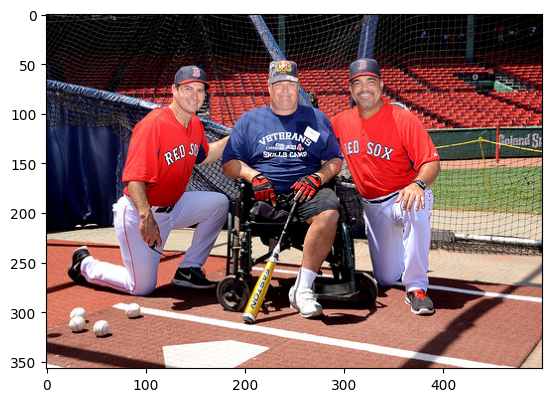

[[[1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]]

 ...

 [[1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]]

 [[1. 1. 1. ... 1. 1. 1.]]]


TypeError: unhashable type: 'numpy.ndarray'

In [56]:
import matplotlib.pyplot as plt
x=plt.imread(images)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(test_graph))